In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [3]:
## Function Lorenz63
def Lorenz63(state, *args):
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state #Unpack the state vector
    f = np.zeros(3) #Derivatives
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f

In [4]:
## Function Lorentz96
def Lorenz96(state, *args):
    N = args[0]
    T = args[1]
    F = args[2]
    new_state = np.zeros(N)  # Setting up vector
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        new_state[i] = (state[(i+1) % N] - state[i-2]) * state[i-1] - state[i] + F
    return new_state

In [5]:
## Classical Runge-Kutta 4
def RK4(rhs, state, dt, *args):
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args)
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

In [79]:
## Euler 1
def euler(rhs, state, dt, *args):
    k1 = rhs(state,*args)
    new_state = state + dt*k1
    return new_state

In [6]:
## Lin3dvar
def Lin3dvar(ub, w, H, R, B, opt):
    
    if opt ==1:  # model-space approach
        Bi = np.linalg.inv(B)
        Ri = np.linalg.inv(R)
        A = Bi + (H.T)@Ri@H
        b = Bi@ub + (H.T)@Ri@w
        ua = np.linalg.solve(A,b)  # solve a linear system
    
    elif opt == 2:  # model-space incremental approach
        Bi = np.linalg.inv(B)
        Ri = np.linalg.inv(R)
        A = Bi + (H.T)@Ri@H
        b = (H.T)@Ri@(w - H@ub)
        ua = ub + np.linalg.solve(A,b)  # solve a linear system
        
    elif opt == 3:  #  observation-space incremental approach
        A = R + H@B@(H.T)
        b = (w - H@ub)
        ua = ub + B@(H.T)@np.linalg.solve(A,b)  # solve a linear system
    
    return ua

In [7]:
## Nonlinear 3dvar
def NonLin3dvar(ub, w, ObsOp, JObsOp, R, B):
    
    Bi = np.linalg.inv(B)
    Ri = np.linalg.inv(R)
    ua = np.copy(ub)
    
    for iter in range(100):
        Dh = JObsOp(ua)
        A = Bi + (Dh.T)@Ri@Dh
        b = Bi@(ub-ua) + (Dh.T)@Ri@(w-ObsOp(ua))
        du = np.linalg.solve(A,b)  # solve a linear system
        ua = ua + du
        
        if np.linalg.norm(du) <= 1e-4:
            break
    return ua

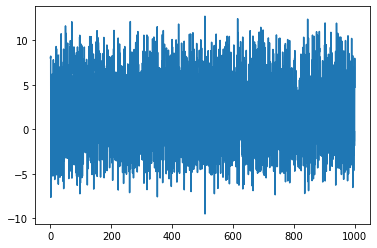

In [125]:
## This is for assignment

# parameters
dt = 0.01
tm = 1000
nt = int(tm/dt)
t = np.linspace(0, tm, nt+1)

N = 40  # sites
F = 8.0  # force
sites = np.arange(1,N+1)

uTrue = np.zeros([N,nt+1])
u0True = np.ones((N)) * F # True initial conditions
u0True[20] += 0.001 * F 

uTrue[:,0] = u0True

# try euler1
for k in range(nt):
    uTrue[:,k+1] = euler(Lorenz96, uTrue[:,k], dt, N, tm, F)

# try RK4
for k in range(nt):
    uTrue[:,k+1] = RK4(Lorenz96, uTrue[:,k], dt, N, tm, F)
    
plt.plot(t,uTrue[1,:])

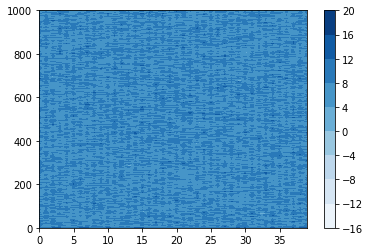

In [126]:
## Hovmoller diagram
def Hov(time, xsol):
  X, T = np.meshgrid(np.arange(0, N), time)

  plt.contourf(X, T, xsol, cmap = 'Blues')
  plt.colorbar()
  plt.show()

Hov(t,np.transpose(uTrue))

In [80]:
#%% Application of Lorenz 63
# parameters
sigma = 10.0
beta = 8.0/3.0
rho = 28.0

dt = 0.01
tm = 10
nt = int(tm/dt)
t = np.linspace(0, tm, nt+1)

u0True = np.array([1,1,1]) # True initial conditions

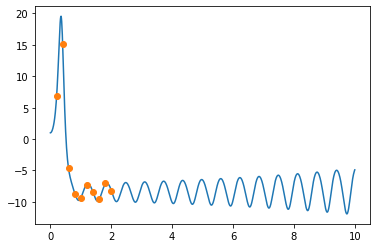

In [46]:
## Twin experiment
np.random.seed(seed=1)
sig_m = 0.15  # standard deviation for measurement noise
R = sig_m**2*np.eye(3)  # covariance matrix for measurement noise
H = np.eye(3)  # linear observation operator

dt_m = 0.2  # time period between observations
tm_m = 2  # maximum time for observations
nt_m = int(tm_m/dt_m)  # number of observation instants

ind_m = (np.linspace(int(dt_m/dt), int(tm_m/dt), nt_m)).astype(int)
t_m = t[ind_m]

# time integration
uTrue = np.zeros([3,nt+1])
uTrue[:,0] = u0True
km = 0
w = np.zeros([3,nt_m])

for k in range(nt):
    uTrue[:,k+1] = RK4(Lorenz63, uTrue[:,k], dt, sigma, beta, rho)
    
    if (km < nt_m) and (k+1 == ind_m[km]):
        w[:,km] = H@uTrue[:,k+1] + np.random.normal(0, sig_m, [3,])
        km = km+1

plt.plot(t, uTrue[0,:])
plt.plot(t_m, w[0,:],'o')

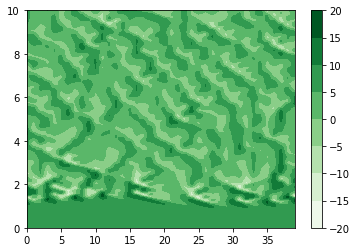

In [57]:
## Data Assimilation
u0b = np.array([2.0,3.0,4.0])
sig_b = 0.1
B = sig_b**2*np.eye(3)

# time integration
ub = np.zeros([3,nt+1])
ub[:,0] = u0b
ua = np.zeros([3,nt+1])
ua[:,0] = u0b
km = 0

for k in range(nt):
    ub[:,k+1] = RK4(Lorenz63, ub[:,k], dt, sigma, beta, rho)
    ua[:,k+1] = RK4(Lorenz63, ua[:,k], dt, sigma, beta, rho)
    
    if (km < nt_m) and (k+1 == ind_m[km]):
        ua[:,k+1] = Lin3dvar(ua[:,k+1], w[:,km], H, R, B, 3)
        km = km+1

In [63]:
## Plotting
mpl.rc('text', usetex = True)
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
font = {'family':'normal', 'weight':'bold', 'size':20}
mpl.rc('font', **font)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
ax = ax.flat

for k in range(3):
    ax[k].plot(t,uTrue[k,:], label=r'\bf{True}', linewidth = 3)
    ax[k].plot(t,ub[k,:], ':', label=r'\bf{Background}', linewidth = 3)
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none', \
               label=r'\bf{Observation}', markersize = 8, markeredgewidth = 2)
    ax[k].plot(t,ua[k,:], '--', label=r'\bf{Analysis}', linewidth = 3)
    ax[k].set_xlabel(r'$t$',fontsize=22)
    ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
    
ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15)
    
ax[0].set_ylabel(r'$x(t)$')
ax[1].set_ylabel(r'$y(t)$')
fig.subplots_adjust(hspace=0.5)

D:\SOFT\Miniconda3\envs\DataAssimilationA\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  This is separate from the ipykernel package so we can avoid doing imports until
D:\SOFT\Miniconda3\envs\DataAssimilationA\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  after removing the cwd from sys.path.


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 720x576 with 3 Axes>

In [64]:
ua

array([[ 2.        ,  2.1172967 ,  2.26865661, ..., -5.39947983,
        -5.16902422, -4.96572706],
       [ 3.        ,  3.46153437,  3.95129975, ..., -2.95836458,
        -3.00075066, -3.06737321],
       [ 4.        ,  3.96031514,  3.93624512, ..., 26.90913359,
        26.35621018, 25.81420178]])